c:\Users\RTX\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Loss: 0.7064, Accuracy: 53.98%
Epoch 2/10
Loss: 0.6374, Accuracy: 66.37%
Epoch 3/10
Loss: 0.5879, Accuracy: 71.68%
Epoch 4/10
Loss: 0.4883, Accuracy: 83.19%
Epoch 5/10
Loss: 0.3971, Accuracy: 84.96%
Epoch 6/10
Loss: 0.2800, Accuracy: 92.04%
Epoch 7/10
Loss: 0.3321, Accuracy: 86.73%
Epoch 8/10
Loss: 0.1795, Accuracy: 95.58%
Epoch 9/10
Loss: 0.1906, Accuracy: 96.46%
Epoch 10/10
Loss: 0.1957, Accuracy: 93.81%


C:\Users\RTX\AppData\Local\Temp\ipykernel_18620\1557087718.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_model.pth'))


Classification Report:
              precision    recall  f1-score   support

      Caries       1.00      0.66      0.79        29
 Non Carious       0.70      1.00      0.82        23

    accuracy                           0.81        52
   macro avg       0.85      0.83      0.81        52
weighted avg       0.87      0.81      0.80        52



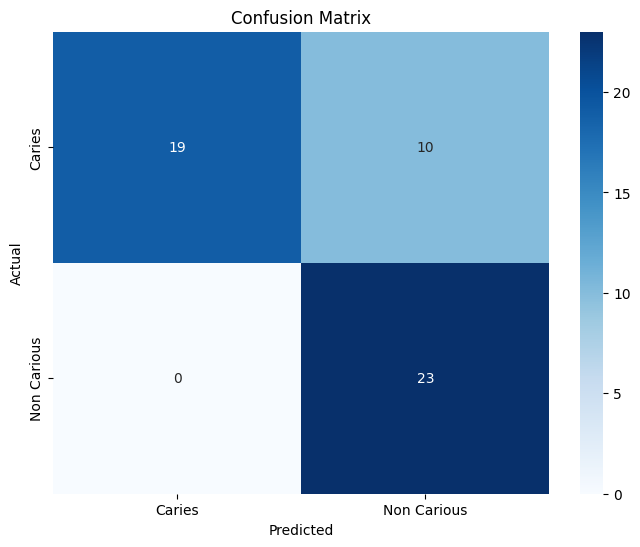

Evaluation complete.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
train_dir = r'd:\paper code\gu data\train'
test_dir = r'd:\paper code\gu data\test'

# Image Dataset Class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(data_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, error: {e}")
            return None, None
        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations with Augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Create Datasets and Loaders
train_dataset = ImageDataset(train_dir, transform=transform)
test_dataset = ImageDataset(test_dir, transform=transform)

# Use num_workers=0 for debugging
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load ViT Model (with classifier adapted to 2 output classes)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        if images is None or labels is None:
            continue  # Skip corrupted images
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Save the model after each epoch or optionally after the last epoch
    torch.save(model.state_dict(), 'vit_model.pth')

# Load the model for evaluation
model.load_state_dict(torch.load('vit_model.pth'))
model.eval()

# Test Loop
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        if images is None or labels is None:
            continue  # Skip corrupted images
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.class_names, yticklabels=train_dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Evaluation complete.")
